# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


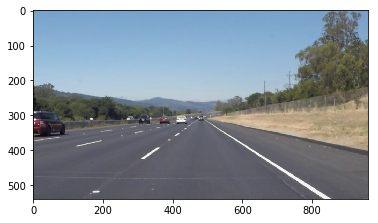

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [70]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_points = []
    left_slopes = []
    right_points = []
    right_slopes = []
    
    max_y = img.shape[0]
    min_y = img.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            point1 = (x1, y1)
            point2 = (x2, y2)

            min_y = min(y1, y2, min_y)
    
            if slope > 0:
                left_slopes.append(slope)
                left_points.append(point1)
                left_points.append(point2)
            else:
                right_slopes.append(slope)
                right_points.append(point1)
                right_points.append(point2)
                
    average_left_slope = np.sum(left_slopes)/len(left_slopes)
    average_right_slope = np.sum(right_slopes)/len(right_slopes)
   
    def calc_average_point(points):
        return np.divide(np.sum(points,axis=0),len(points))
    
    def calc_x(point, slope, y):
        x = ((y - point[1]) / slope) + point[0]
        return int(x)
    
    def drawLine(slope, point):
        x1 = calc_x(point, slope, min_y)
        x2 = calc_x(point, slope, max_y)
        cv2.line(img, (x1, min_y), (x2, max_y), color, thickness)
    
    left_average_point = calc_average_point(left_points)
    right_average_point = calc_average_point(right_points)
    
    drawLine(average_left_slope, left_average_point)
    drawLine(average_right_slope, right_average_point)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [71]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

[ 739.25   457.125]
[ 686.75        440.08333333]
[ 573.75  369.5 ]
[ 658.94444444  416.55555556]
[ 660.125  418.75 ]
[ 673.61111111  420.94444444]


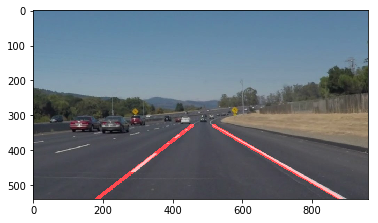

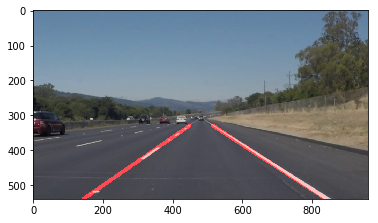

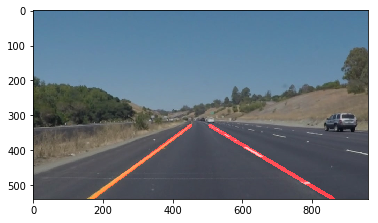

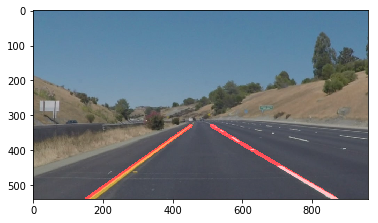

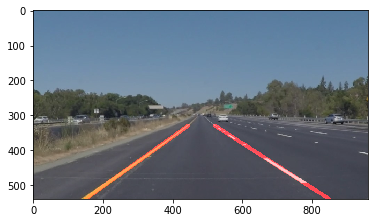

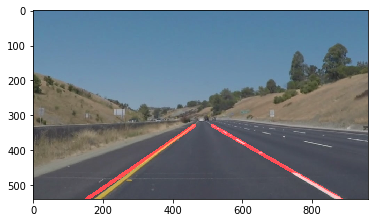

In [72]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def detectLine(image):
    gray = grayscale(image)
    blur = gaussian_blur(gray, 5)
    edges = canny(blur, 50, 150)

    vertices = np.array([[(100, image.shape[0]),(400, 330), (550, 330), (900, image.shape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    lines = hough_lines(masked_edges, 1, np.pi/180, 15, 40, 20)
    combo = weighted_img(lines, image)
    plt.imshow(combo)
    return combo

directory = "test_images/"
for file_name in os.listdir(directory):
    image = mpimg.imread(directory + file_name)
    detected = detectLine(image)
    plt.imshow(detected)
    plt.figure()
    cv2.imwrite("test_images_output/" + file_name, image)
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [68]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return detectLine(image)

Let's try the one with the solid white lane on the right first ...

518 860
441 160
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|          | 2/222 [00:00<00:11, 19.90it/s]

518 860
441 160
518 857
445 154
519 858
444 156
517 857
446 156
520 863


  2%|▏         | 5/222 [00:00<00:09, 21.81it/s]

444 151


  4%|▎         | 8/222 [00:00<00:09, 23.23it/s]

519 860
444 146
522 864
443 147
521 864
443 155
516 858
444 150


  5%|▍         | 11/222 [00:00<00:08, 24.78it/s]

515 857
447 150
511 853
448 157
514

  6%|▋         | 14/222 [00:00<00:08, 25.27it/s]

 848
450 155
514 843
448 156
517 848
443 150
517 848
445 143


  8%|▊         | 17/222 [00:00<00:07, 26.29it/s]

523 846
445 142
524 843
441 139
524 844
442 138


  9%|▉         | 20/222 [00:00<00:07, 25.52it/s]

519 846
443 143
516 842
447 141
514 843
449 146
516 843
448 153


 10%|█         | 23/222 [00:00<00:09, 20.83it/s]

517 847
444 158
517 843
449 145
514 843
444 147


 12%|█▏        | 26/222 [00:01<00:10, 18.05it/s]

520 839
445 149
517 844
450 146
517 842
446 152
517 846
447 153


 14%|█▎        | 30/222 [00:01<00:09, 20.66it/s]

518 847
443 164
519 848
444 143


 15%|█▍        | 33/222 [00:01<00:08, 21.71it/s]

520 852
442 156
521 851
444 146
519 848
441 162
518 849
443 155


 16%|█▌        | 36/222 [00:01<00:07, 23.61it/s]

517 849
443 158
517 847
445 157
519 841
446 157
518 845
442 154


 18%|█▊        | 39/222 [00:01<00:08, 20.72it/s]

520 842
446 149


 19%|█▉        | 42/222 [00:01<00:09, 19.23it/s]

521 838
443 151
521 842
441 157
521 846
440 156
525 846
440 142


 20%|██        | 45/222 [00:02<00:09, 19.23it/s]

521 846
439 153
521 845
441 152
522 848
439 151
524 844
441 146


 22%|██▏       | 48/222 [00:02<00:09, 17.66it/s]

520 843
442 146
520 846
443 144


 23%|██▎       | 50/222 [00:02<00:10, 15.91it/s]

520 847
441 145


 23%|██▎       | 52/222 [00:02<00:11, 14.61it/s]

520 848
439 145
522 845
440 136
520

 25%|██▍       | 55/222 [00:02<00:10, 16.10it/s]

 846
439 139
518 845
441 137


 26%|██▌       | 57/222 [00:02<00:09, 16.91it/s]

518 842
439 145
518 839
442 141
514 839
448 131
515 838
446 135
519 839


 28%|██▊       | 62/222 [00:03<00:08, 18.54it/s]

443 140
517 838
444 137
521 839
442 137
515 842
446 136


 29%|██▉       | 64/222 [00:03<00:08, 18.56it/s]

513 838
447 134
516 835
442 136

 30%|██▉       | 66/222 [00:03<00:09, 17.33it/s]


516 834
444 107
518 840
441 124
520 840
441 130


 31%|███       | 69/222 [00:03<00:08, 18.06it/s]

518 842
441 130
517 837
445 

 32%|███▏      | 72/222 [00:03<00:07, 19.06it/s]

131
517 834
442 133
518 837
442 128
516 

 33%|███▎      | 74/222 [00:03<00:07, 18.53it/s]

834
440 127
517 832
443 125
515 834
442 128


 34%|███▍      | 76/222 [00:03<00:08, 18.21it/s]

516 831
442 126


 36%|███▌      | 79/222 [00:03<00:07, 20.02it/s]

515 831
438 121
516 823
439 119
515 824
440 118
516 821
440 120
514 825
438 129


 37%|███▋      | 82/222 [00:04<00:07, 19.66it/s]

516 827
440 120
515 829
440 121
519 824
440 122
517 825
440 

 38%|███▊      | 85/222 [00:04<00:06, 20.12it/s]

123


 40%|███▉      | 88/222 [00:04<00:06, 20.02it/s]

515 828
442 118
519 826
441 122
510 833
442 124
516 819
440 125
515 823
441 120


 42%|████▏     | 93/222 [00:04<00:06, 18.85it/s]

515 821
444 127
516 819
444 124
518 815
443 132
516 819
446 121


 43%|████▎     | 95/222 [00:04<00:06, 18.48it/s]

519 822
445 124
519 825
442 123
521 821
444 123


 45%|████▌     | 101/222 [00:05<00:07, 16.67it/s]

522 824
444 122
524 822
444 118
524 823
441 127
525 826
442 123
519 

 47%|████▋     | 105/222 [00:05<00:06, 17.02it/s]

822
442 137
519 823
446 125
520 825
447 130
522 828
447 127
522 828
444 137


 49%|████▉     | 109/222 [00:05<00:07, 16.07it/s]

523 828
445 134
525 830
445 135
521 829
447 132


 51%|█████     | 113/222 [00:05<00:06, 16.48it/s]

524 831
452 130
523 829
449 134
525 830
450 134
525 833
449 127


 52%|█████▏    | 116/222 [00:06<00:05, 17.84it/s]

522 834
446 129
526 835
443 143
525 839
444 140
524 836
446 133
524 840
448 119


 55%|█████▍    | 122/222 [00:06<00:05, 18.25it/s]

524 839
443 137
523 834
444 137
520 844
444 143
523 844
448 139


 56%|█████▌    | 124/222 [00:06<00:05, 17.33it/s]

519 848
446 139
520 845
446 139
523 844
448 134
520 847
449 143


 58%|█████▊    | 128/222 [00:06<00:06, 15.38it/s]

519 848
448 143
520 848
449 146
521 850
449 150


 59%|█████▊    | 130/222 [00:06<00:06, 14.90it/s]

520 851
450 147
520 852
452 150
520 851
452 147


 60%|██████    | 134/222 [00:07<00:07, 11.85it/s]

521 855
450 153
521 848
446 155


 61%|██████▏   | 136/222 [00:07<00:07, 12.15it/s]

523 850
450 147
526 854
446 148
526 858
449 145


 62%|██████▏   | 138/222 [00:07<00:08,  9.94it/s]

527 857
445 151
525 853
446 149


 64%|██████▍   | 142/222 [00:08<00:06, 12.62it/s]

522 853
448 160
522 852
450 152
520 848
450 158
520 851
449 164


 66%|██████▌   | 146/222 [00:08<00:05, 14.60it/s]

521 849
449 159
520 852
447 165
526 852
450 158
527 857


 67%|██████▋   | 148/222 [00:08<00:05, 12.49it/s]

446 162
526 862
449 159
526 860
447 160
526 858

 69%|██████▉   | 153/222 [00:08<00:04, 14.80it/s]


448 165
525 861
447 165
528 859
451 166
526 856
451 163
528 862
452 149
527 858
447 162
530 865
450 159
529 868
449 163


 73%|███████▎  | 163/222 [00:09<00:02, 22.16it/s]

524 865
447 166
525 868
451 158
527 867
449 167
526 876
454 163
528 873
452 178
527 876
451 170
522

 76%|███████▌  | 169/222 [00:09<00:02, 25.28it/s]

 878
453 176
523 879
453 172
523 877
454 173
521 874
452 176
521 879
453 180
520 878
451 183
522 879
454 176
522

 77%|███████▋  | 172/222 [00:09<00:01, 26.04it/s]

 880
452 180
520 879
449 186
522 874
451 182
522 877
450 187
519 882
450 186


 80%|████████  | 178/222 [00:09<00:02, 19.68it/s]

521 877
452 188
521 876
451 185
521 874
451 191
522 879
450 188
524 877
450 187


 83%|████████▎ | 184/222 [00:10<00:01, 19.55it/s]

526 883
449 191
529 880
453 186
523 880
449 190
517 865
452 185


 84%|████████▍ | 187/222 [00:10<00:01, 19.79it/s]

527 881
451 185
528 877
448 189
524 879
450 191
527 885
449 190


 87%|████████▋ | 193/222 [00:10<00:01, 20.16it/s]

531 889
445 178
535 891
441 179
532 890
445 182
527 897
449 178
521 890
451 188
524

 90%|█████████ | 200/222 [00:10<00:00, 23.78it/s]

 881
454 183
525 882
449 190
521 874
455 185
523 881
449 185
523 881
449 189
524 881
448 184
523 880
449 193


 92%|█████████▏| 204/222 [00:10<00:00, 25.43it/s]

525 885
488 120
519 892
446 186
523 889
448 186
522 894
447 188
529 888
449 178
523 892
449 185
523 893
448 181


 96%|█████████▌| 213/222 [00:11<00:00, 26.39it/s]

525 895
447 182
525 894
447 184
523 896
446 184
523 891
447 182
523 895
449 181
521 892
450 178


 97%|█████████▋| 216/222 [00:11<00:00, 26.89it/s]

518 890
449 185
519 891
451 183
519 887
455 182
517 887
456 180
518 889
452 188
518 891
448 188
518 888
451 180


100%|█████████▉| 221/222 [00:11<00:00, 19.12it/s]


520 890
453 180
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.52 s, sys: 1.48 s, total: 9.01 s
Wall time: 12.3 s


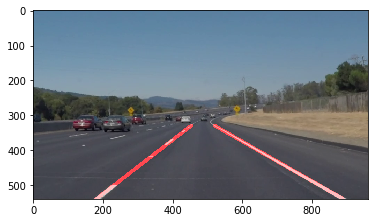

In [69]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [82]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [84]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:17<00:00, 38.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.3 s, sys: 1.93 s, total: 12.2 s
Wall time: 18.2 s


In [85]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))